In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [3]:
def load_data(file_path):
  df = pd.read_excel(file_path)
  df = df.rename(columns = {"T2M":"temp", "CLRSKY_SFC_SW_DWN":"clear_sky_rad", "ALLSKY_SFC_SW_DWN":"all_sky_rad", "Value":"power" })
  df = df[['temp', 'clear_sky_rad', 'all_sky_rad', "power"]]
  return df

In [4]:
file_path = "/content/cleaned_data_for_solar_forecasting.xlsx"
df = load_data(file_path)
df

,temp,clear_sky_rad,all_sky_rad,power
0,27.20,0.0,0.0,0.0
1,26.74,0.0,0.0,0.0
2,26.51,0.0,0.0,0.0
3,26.23,0.0,0.0,0.0
4,26.09,0.0,0.0,0.0
...,...,...,...,...
31435,18.55,0.0,0.0,0.0
31436,17.77,0.0,0.0,0.0
31437,17.02,0.0,0.0,0.0
31438,16.32,0.0,0.0,0.0


In [5]:
int(31440/24) # train -> 1000, valid -> 100, test -> 210

1310

In [6]:
def check_nans(df):
  x = df.isnull().sum().sum()
  print(x)

In [7]:
check_nans(df)

0


In [8]:
def plot_cols(df):
  fig, axs = plt.subplots(4, figsize=(10, 8))
  fig.suptitle('Plotting the columns of the data')
  for i, col in enumerate(df.columns):
    axs[i].plot(df[col])

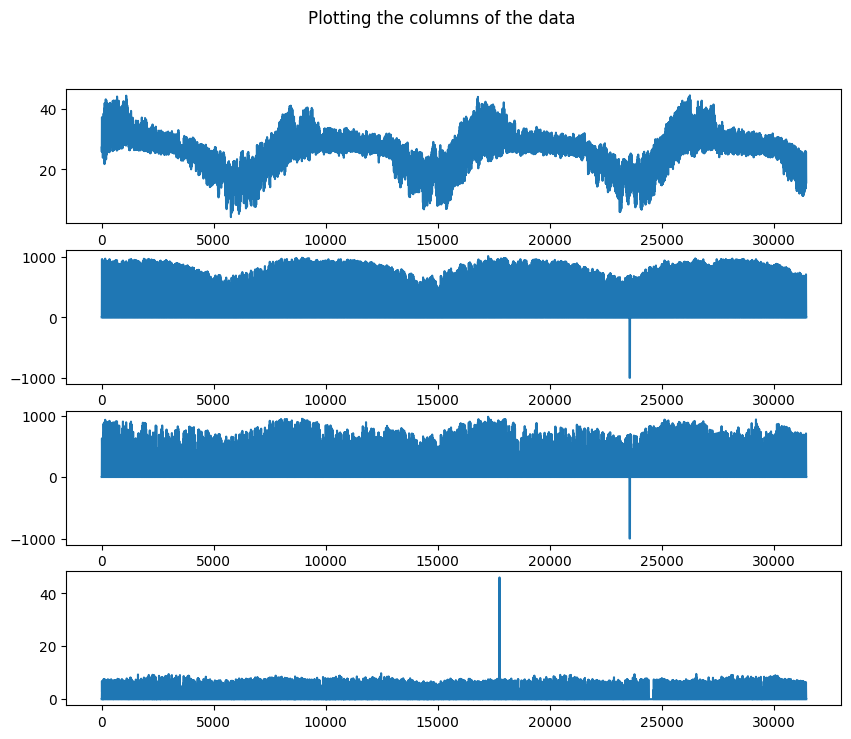

In [9]:
plot_cols(df)

In [10]:
def clean_negatives(df):
  df = df.mask(df<0, 0)
  return df

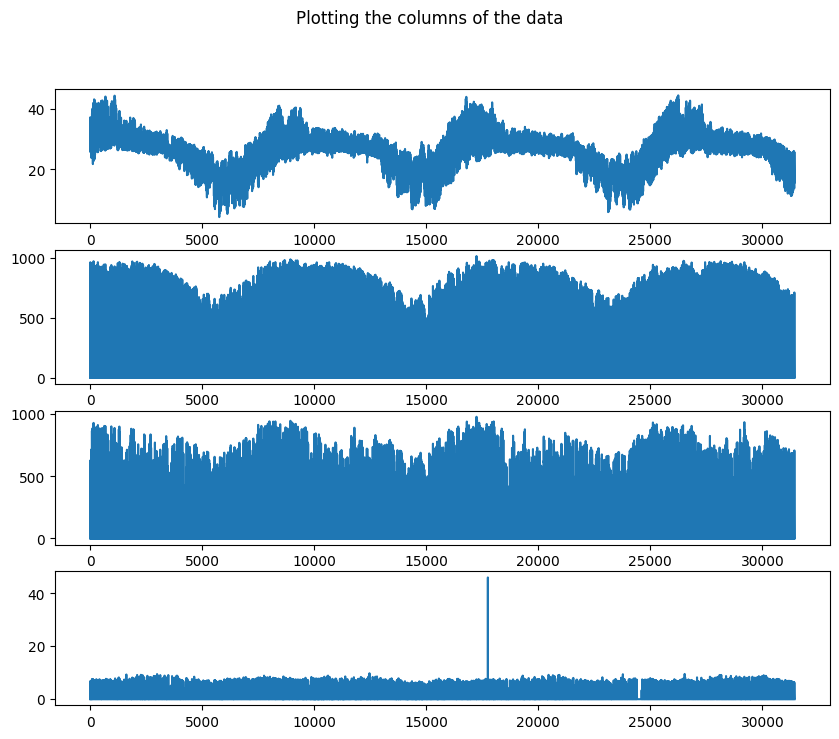

In [11]:
df = clean_negatives(df)
plot_cols(df)

In [12]:
# as we don't have anamolies in the power productions we can remove the spike in the power graph
np.where(df.power > 20)
df.power.iloc[17751] = 7
df.power.iloc[17751]

7.0

In [13]:
np.sum(df.power>7.5)

438

In [14]:
df.power

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
31435    0.0
31436    0.0
31437    0.0
31438    0.0
31439    0.0
Name: power, Length: 31440, dtype: float64

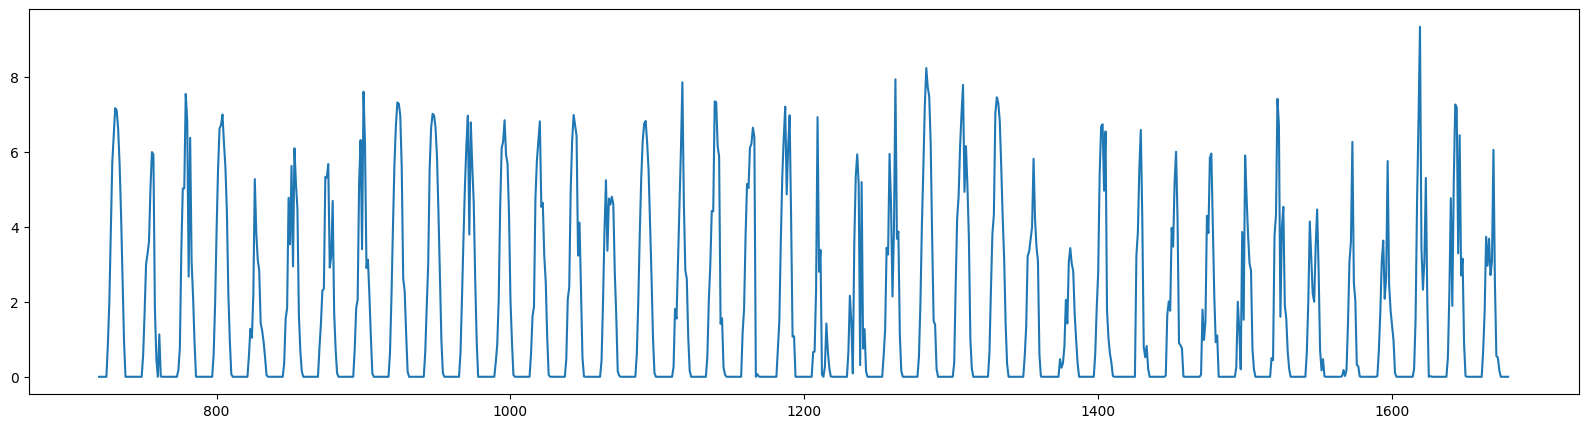

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(df.power[24*30:24*70])
plt.show()

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  i = 1
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [f'var{df.columns[j]}(t-{i})' for j in range(n_vars)]

  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i==0:
      names += [f'var{df.columns[j]}(t)' for j in range(n_vars)]
    else:
      names += [f'var{df.columns[j](t+{i})}' for j in range(n_vars)]
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  if dropnan==True:
    agg.dropna(inplace=True)
  return agg

In [17]:
df

,temp,clear_sky_rad,all_sky_rad,power
0,27.20,0.0,0.0,0.0
1,26.74,0.0,0.0,0.0
2,26.51,0.0,0.0,0.0
3,26.23,0.0,0.0,0.0
4,26.09,0.0,0.0,0.0
...,...,...,...,...
31435,18.55,0.0,0.0,0.0
31436,17.77,0.0,0.0,0.0
31437,17.02,0.0,0.0,0.0
31438,16.32,0.0,0.0,0.0


In [18]:
def normalize_features(df):
  values = df.values
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  return scaled

In [19]:
[i for i in range(4*32, 4*33-1)]

[128, 129, 130]

In [20]:
prev_hour_lookback = 24

In [21]:
scaled = normalize_features(df)
reframed = series_to_supervised(scaled, prev_hour_lookback, 1) # --> tune
reframed.drop(reframed.columns[[i for i in range(4*prev_hour_lookback, 4*(prev_hour_lookback+1)-1)]], axis=1, inplace=True)

In [22]:
reframed

,var0(t-24),var1(t-24),var2(t-24),var3(t-24),var0(t-23),var1(t-23),var2(t-23),var3(t-23),var0(t-22),var1(t-22),...,var3(t-3),var0(t-2),var1(t-2),var2(t-2),var3(t-2),var0(t-1),var1(t-1),var2(t-1),var3(t-1),var3(t)
24,0.571464,0.0,0.0,0.0,0.560050,0.000000,0.000000,0.0,0.554342,0.000000,...,0.000000,0.586849,0.000000,0.000000,0.0,0.572705,0.0,0.0,0.0,0.0
25,0.560050,0.0,0.0,0.0,0.554342,0.000000,0.000000,0.0,0.547395,0.000000,...,0.000000,0.572705,0.000000,0.000000,0.0,0.562283,0.0,0.0,0.0,0.0
26,0.554342,0.0,0.0,0.0,0.547395,0.000000,0.000000,0.0,0.543921,0.000000,...,0.000000,0.562283,0.000000,0.000000,0.0,0.553846,0.0,0.0,0.0,0.0
27,0.547395,0.0,0.0,0.0,0.543921,0.000000,0.000000,0.0,0.536228,0.003379,...,0.000000,0.553846,0.000000,0.000000,0.0,0.548139,0.0,0.0,0.0,0.0
28,0.543921,0.0,0.0,0.0,0.536228,0.003379,0.006776,0.0,0.561290,0.102917,...,0.000000,0.548139,0.000000,0.000000,0.0,0.544417,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31435,0.379901,0.0,0.0,0.0,0.364268,0.000000,0.000000,0.0,0.344665,0.000000,...,0.059184,0.404715,0.004248,0.007367,0.0,0.375186,0.0,0.0,0.0,0.0
31436,0.364268,0.0,0.0,0.0,0.344665,0.000000,0.000000,0.0,0.323573,0.000000,...,0.000000,0.375186,0.000000,0.000000,0.0,0.356824,0.0,0.0,0.0,0.0
31437,0.344665,0.0,0.0,0.0,0.323573,0.000000,0.000000,0.0,0.305955,0.000000,...,0.000000,0.356824,0.000000,0.000000,0.0,0.337469,0.0,0.0,0.0,0.0
31438,0.323573,0.0,0.0,0.0,0.305955,0.000000,0.000000,0.0,0.293300,0.000000,...,0.000000,0.337469,0.000000,0.000000,0.0,0.318859,0.0,0.0,0.0,0.0


In [23]:
days = 31440/24
train_days = int(days*0.8)
test_days = int(days*0.2)
train_days, test_days

(1048, 262)

In [24]:
days

1310.0

In [25]:
values = reframed.values
train_hours = train_days*24
train = values[:train_hours, :]
# valid = values[1000*24:1100*24, :]
test = values[train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [26]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((25152, 96), (25152,), (6264, 96), (6264,))

#### Reshaping the data

In [27]:
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((25152, 1, 96), (25152,), (6264, 1, 96), (6264,))

***Shape of the data : (samples , time_steps, features)***

***y_train : (time_steps, samples)***

So the Training data is made up of 25152 samples looking back over past 1 hour with 4 features

The Testing data is made up of 25152 predicting for every

In [28]:
train_X.shape

(25152, 1, 96)

In [29]:
64*393

25152

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [31]:
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_y_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length, num_features)
        # Initialize h0 and c0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # out shape: (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Use only the output of the last time step
        # out shape: (batch_size, output_size)
        return out


In [33]:
input_size = 4*prev_hour_lookback  # Number of features at each time step # 4
hidden_size = 64
num_layers = 5 # 2
output_size = 1  # For regression tasks, set output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [34]:
criterion = nn.MSELoss()  # Mean Squared Error loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.001

Epoch [1/30], Train Loss: 0.0154, Test Loss: 0.0117
Epoch [2/30], Train Loss: 0.0091, Test Loss: 0.0119
Epoch [3/30], Train Loss: 0.0086, Test Loss: 0.0118
Epoch [4/30], Train Loss: 0.0083, Test Loss: 0.0116
Epoch [5/30], Train Loss: 0.0082, Test Loss: 0.0113
Epoch [6/30], Train Loss: 0.0081, Test Loss: 0.0111
Epoch [7/30], Train Loss: 0.0080, Test Loss: 0.0109
Epoch [8/30], Train Loss: 0.0079, Test Loss: 0.0107
Epoch [9/30], Train Loss: 0.0079, Test Loss: 0.0105
Epoch [10/30], Train Loss: 0.0078, Test Loss: 0.0102
Epoch [11/30], Train Loss: 0.0078, Test Loss: 0.0099
Epoch [12/30], Train Loss: 0.0077, Test Loss: 0.0097
Epoch [13/30], Train Loss: 0.0077, Test Loss: 0.0094
Epoch [14/30], Train Loss: 0.0076, Test Loss: 0.0091
Epoch [15/30], Train Loss: 0.0076, Test Loss: 0.0088
Epoch [16/30], Train Loss: 0.0075, Test Loss: 0.0085
Epoch [17/30], Train Loss: 0.0075, Test Loss: 0.0082
Epoch [18/30], Train Loss: 0.0075, Test Loss: 0.0080
Epoch [19/30], Train Loss: 0.0074, Test Loss: 0.0078
Ep

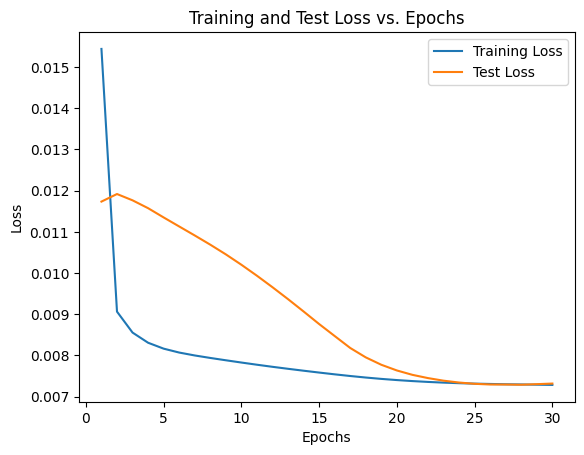

In [35]:
# ... (Previous code for data preparation and model definition)

# Lists to store the loss values for each epoch
train_loss_history = []
test_loss_history = []

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_loss_history.append(epoch_train_loss)

    # Calculate test loss for this epoch
    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            test_loss = criterion(outputs.squeeze(), batch_y)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_loader)
    test_loss_history.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

print("Training finished.")

# Plot the train and test loss vs. epochs
plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs. Epochs')
plt.legend()
plt.show()

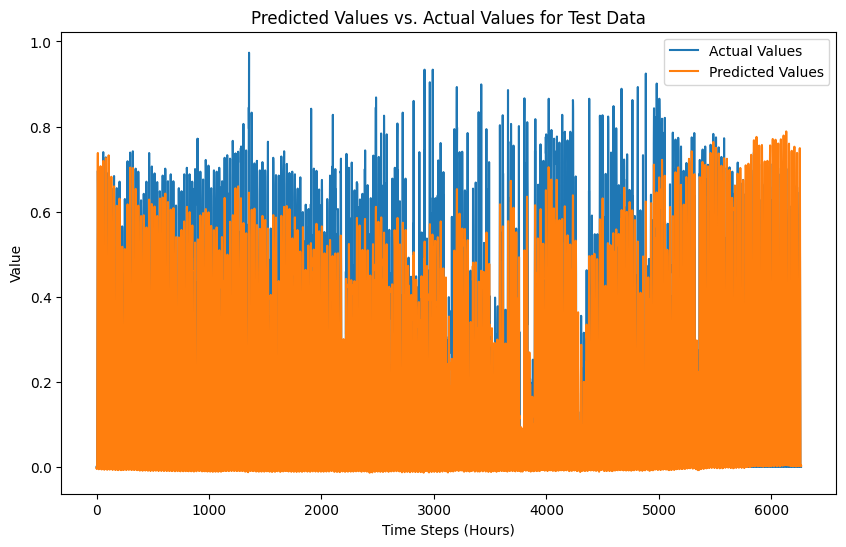

In [36]:
model.eval()
with torch.no_grad():
    predicted_values = model(test_X_tensor)

predicted_values = predicted_values.squeeze().numpy()


plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Time Steps (Hours)')
plt.ylabel('Value')
plt.title('Predicted Values vs. Actual Values for Test Data')
plt.legend()
plt.show()

## Tuning History

In [37]:
prev_hour_lookback = 24

num_layers = 5

lr = 0.001

num_epochs = 30

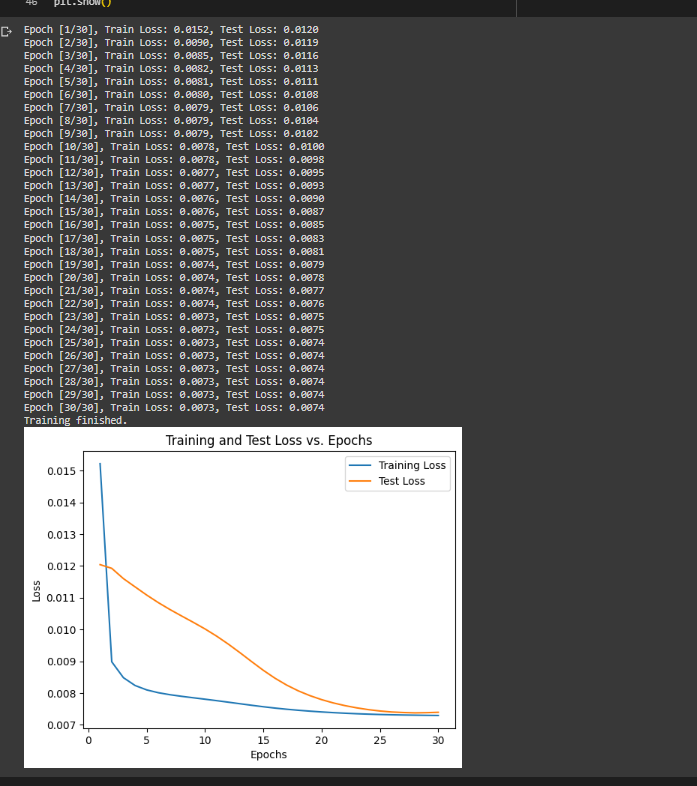

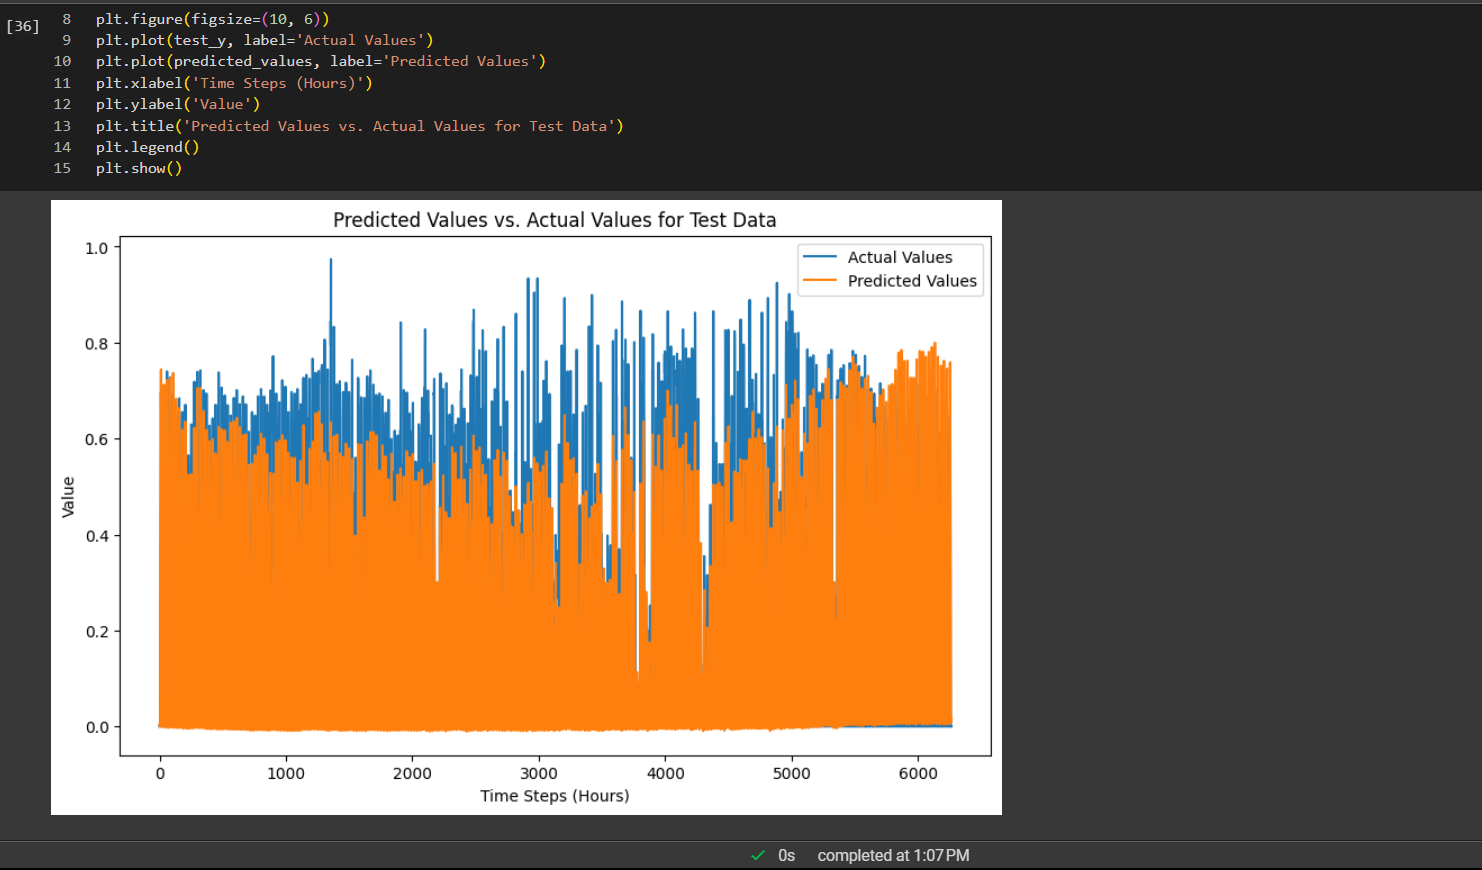

In [38]:
prev_hour_lookback = 24

num_layers = 10

lr = 0.001

num_epochs = 30

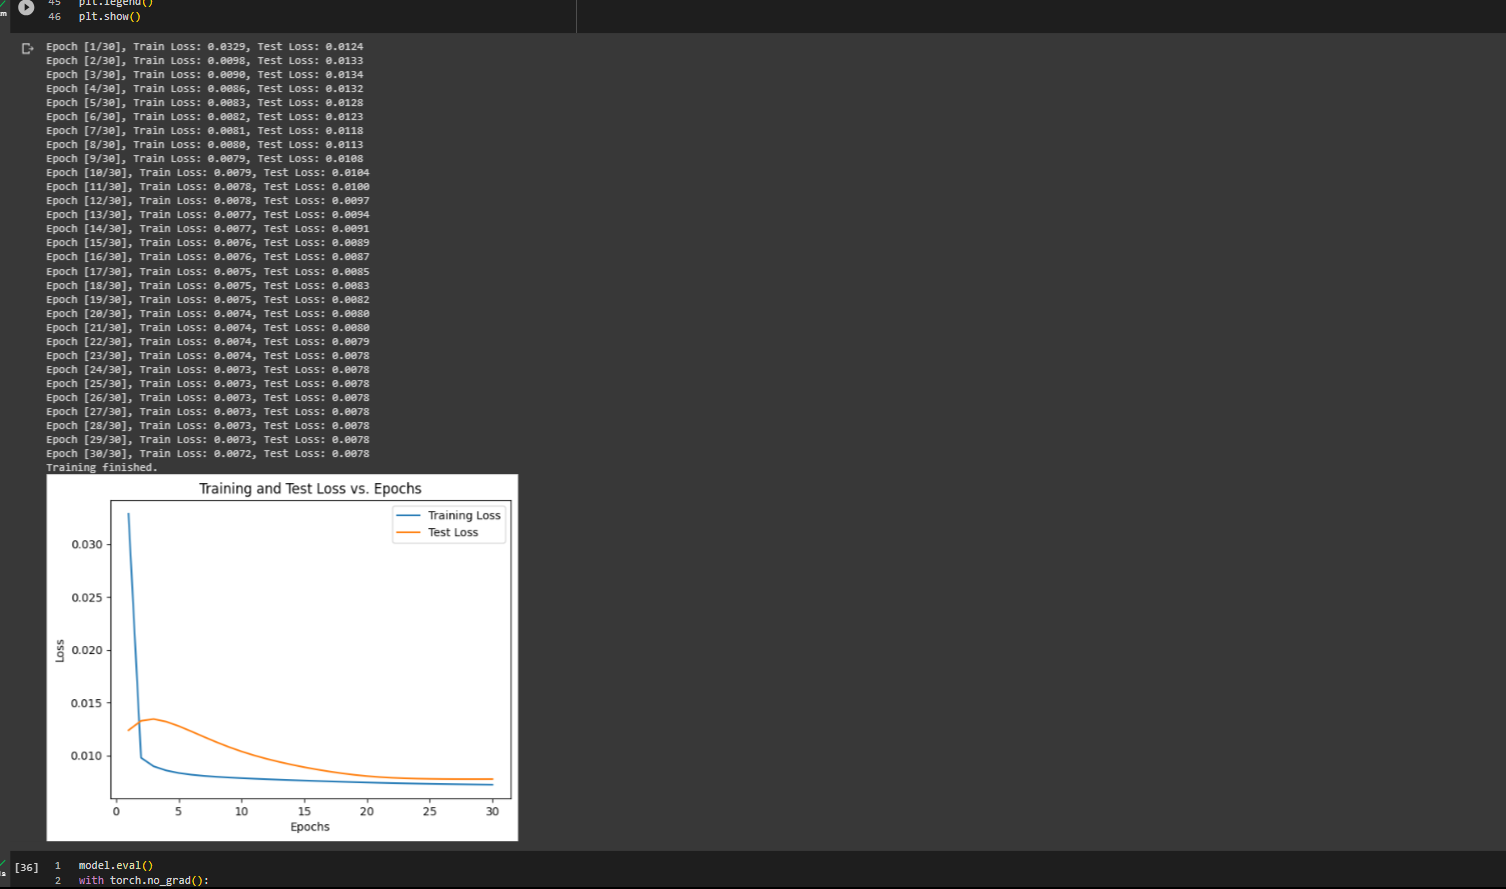

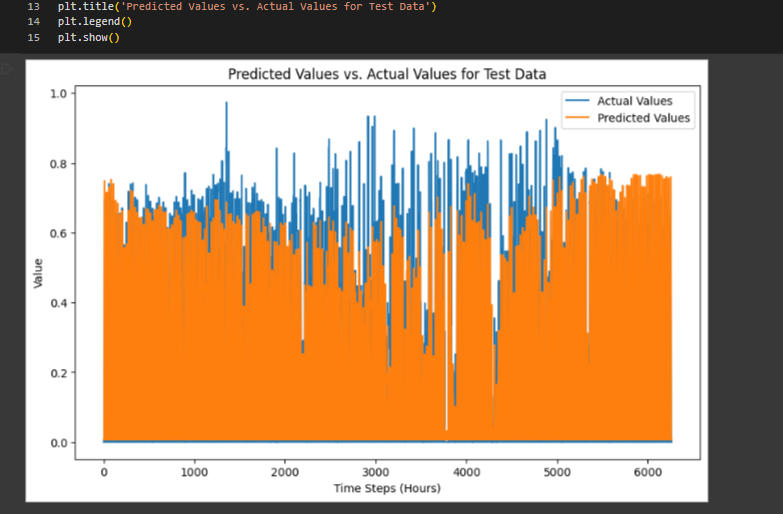

In [39]:
prev_hour_lookback = 32

num_layers = 10

lr = 0.001

num_epochs = 20

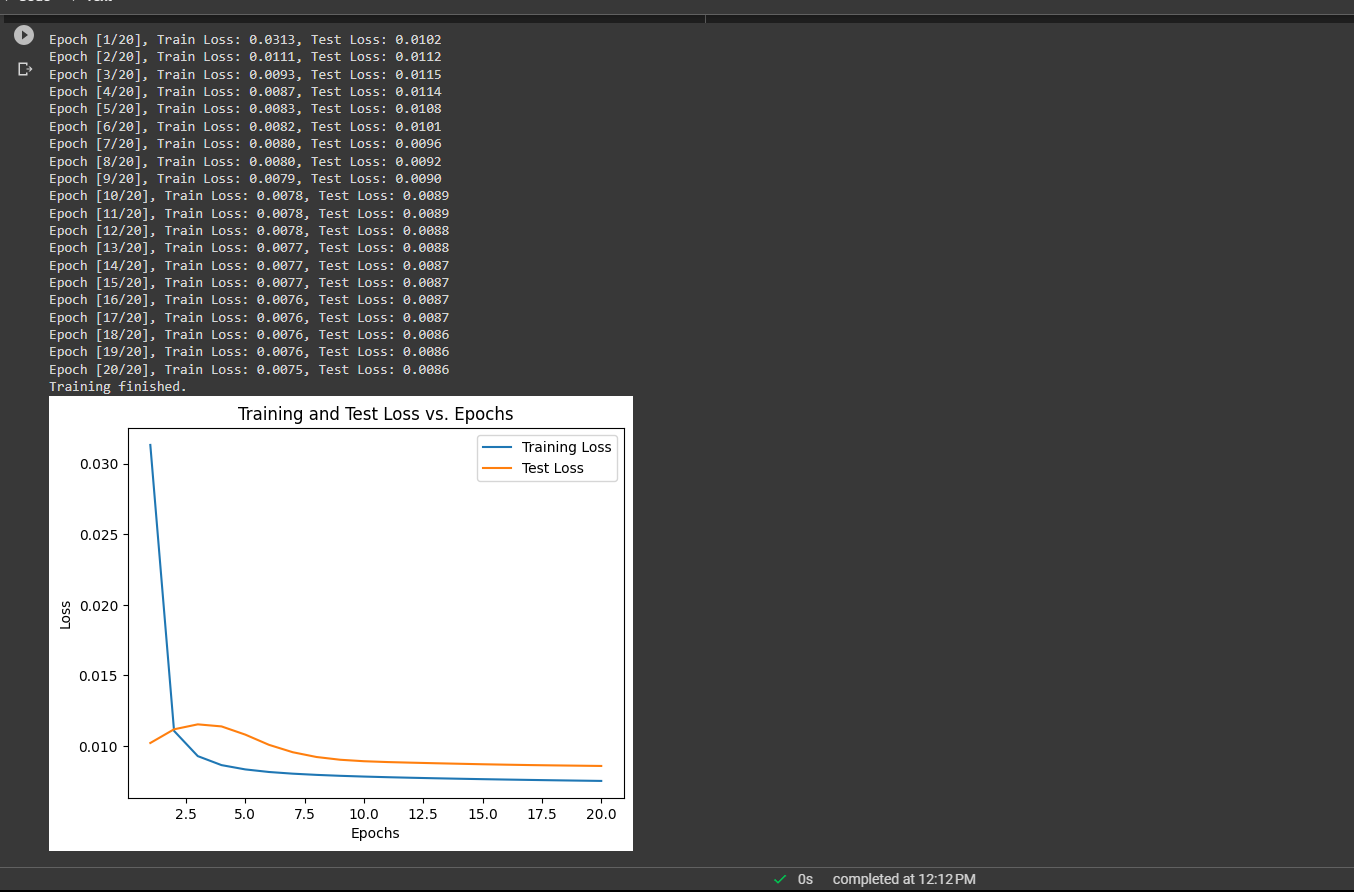

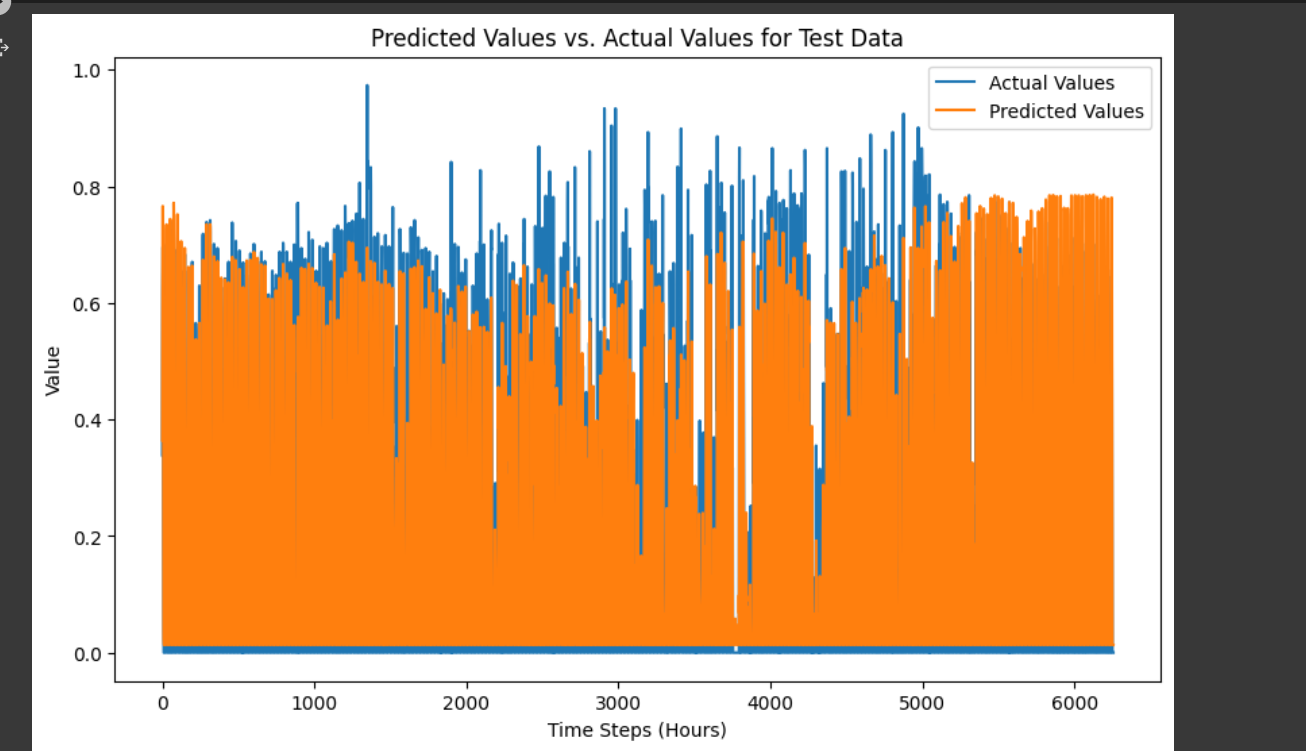